# Анализ и обработка отзывов

In [1]:
import pandas as pd
from tqdm import tqdm
import pymorphy3

# Инициализация морфологического анализатора для работы с русским языком
morph_analyzer = pymorphy3.MorphAnalyzer()


class CreateDataset:
	def __init__(self):
		# Определяем ключевые слова для категорий отзывов
		self.practice = {'задачи', 'кейс', 'проект', 'задания'}  # Слова, связанные с практикой
		self.theory = {'знания', 'лекция', 'материал'}  # Слова, связанные с теорией
		self.technology = {'проблема', 'ресурсы', 'инструменты', 'доступность',
						   'интерактивность'}  # Слова, связанные с технологиями
		self.teacher = {'лектор', 'учитель', 'профессор', 'наставник', 'педагог', 'препод', 'автор',
						'создатель'}  # Слова, связанные с преподавателем
		self.relevance = {'полезный', 'современный', 'релевантный', 'новый', 'старый',
						  'устарел'}  # Слова, связанные с актуальностью

		# Список ключевых тем
		self.topic_keywords = ['практика', 'теория', 'преподаватель', 'технологии', 'актуальность']

		# Создаем словарь, где ключевые темы связываются с набором соответствующих слов
		self.topics = {keyword: {keyword} for keyword in self.topic_keywords}

		# Обновляем словарь ключевых тем с учетом различных словоформ
		self.topics['практика'].update(self.practice)
		self.topics['теория'].update(self.theory)
		self.topics['преподаватель'].update(self.teacher)
		self.topics['технологии'].update(self.technology)
		self.topics['актуальность'].update(self.relevance)

	def names_in_text(self, text: str) -> bool:
		"""
        Проверяет, содержатся ли в тексте имена преподавателей.
        :param text: Исходный текст
        :return: True, если найдено хотя бы одно имя, иначе False
        """
		skip_names = frozenset('паскаль')  # Исключаемое имя (например, Паскаль)
		for word in text:
			if word not in skip_names:
				parse = morph_analyzer.parse(word)[0]
				tag = parse.tag
				# Проверяем, является ли слово именем или фамилией с высокой вероятностью
				if ('Name' in tag or 'Surn' in tag) and parse.score >= 0.8:
					return True
		return False

	def automatic_annotation(self, df: pd.DataFrame) -> pd.DataFrame:
		"""
        Автоматическая разметка обучающего набора данных на основе ключевых слов и имен преподавателей.
        :param df: DataFrame с текстами для разметки
        :return: Размеченный DataFrame
        """
		# Подготовка структуры для хранения данных
		data_all = {t: [] for t in self.topic_keywords}
		data_index = set()

		# Проходим по каждому тексту в DataFrame
		for idx, row in tqdm(df.iterrows(), total=len(df)):
			preprocessed_text = row['PreprocessedText'].split()  # Предобработанный текст
			data = []
			for key, keywords in self.topics.items():
				# Проверяем наличие ключевых слов в тексте с использованием нечеткого поиска
				if any(True for keyword in keywords for word in preprocessed_text if fuzz.ratio(word, keyword) > 78):
					data_index.add(idx)
					data.append(1)
				elif key == 'преподаватель' and self.names_in_text(preprocessed_text):
					# Дополнительная проверка на наличие имен преподавателей
					data_index.add(idx)
					data.append(1)
				else:
					# Если текст не относится к категории
					data.append(0)
			if sum(data) > 0:
				# Добавляем данные в соответствующие столбцы
				for i, key in enumerate(self.topic_keywords):
					data_all[key].append(data[i])
		return pd.DataFrame(data_all, index=sorted(data_index))

## Обработка текста

In [2]:
# Импортируем датасет с отзывами
import pandas as pd
from thefuzz import fuzz  # Новая версия библиотеки fuzzywuzzy
import nltk

# Загрузка необходОгромная благодарность авторам за труд! Полезный материал пра…имых данных для NLTK
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# from utils import CreateDataset

# Загрузка стоп-слов
stop_words = stopwords.words('russian')

# Загрузка данных
df = pd.read_csv('../data/train_reviews.csv', index_col=0)
df['Reviews'] = df['Reviews'].astype(str)

# Замена кириллической 'с' на латинскую
df['Reviews'] = df['Reviews'].apply(
	lambda x: x.replace('1с', '1c').replace('с#', 'c#').replace('с+', 'c+').replace('Ё', 'Е').replace(
		'1С', '1C').replace('С#', 'C#').replace('С+', 'C+'))


class TextProcessor:
	def preprocess(self, text: str) -> str:
		"""
        Предобрабатывает текст, токенизируя, лемматизируя и удаляя стоп-слова.

        :param text: Входной текст, который необходимо предобработать.
        :return: Список предобработанных слов.
        """
		tokens = word_tokenize(text.lower())
		filtered_tokens = [
			normalized_word
			for word in tokens
			if (normalized_word := morph_analyzer.parse(self._remove_symbols(word))[0].normal_form) not in stop_words
		]

		filtered_tokens = " ".join(filtered_tokens).replace('ё', 'е').split()  # Удаление лишних пробелов
		return " ".join(filtered_tokens)

	@staticmethod
	def _remove_symbols(text: str) -> str:
		"""Удаляет все символы и цифры из строки."""
		clean_text = "".join(char if char.isalnum() and not char.isdigit() else " " for char in text)
		return clean_text

[nltk_data] Downloading package stopwords to /home/guru-
[nltk_data]     proger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/guru-
[nltk_data]     proger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
text_processor = TextProcessor()

# Применение предобработки к отзывам
df['PreprocessedText'] = df['Reviews'].apply(text_processor.preprocess)
# Создание списка всех стеммированных слов
all_words = [word for sublist in df['PreprocessedText'] for word in sublist]
unique_words = pd.Series(all_words).value_counts()

# Создание DataFrame с размеченными данными
create_dataset = CreateDataset()
df_dataset_index = create_dataset.automatic_annotation(df)

100%|██████████| 4576/4576 [00:07<00:00, 614.22it/s]


Просмотр размеченных текстов

Всего размеченных текстов - 2342
практика - 1225
теория - 992
преподаватель - 992
технологии - 231
актуальность - 531


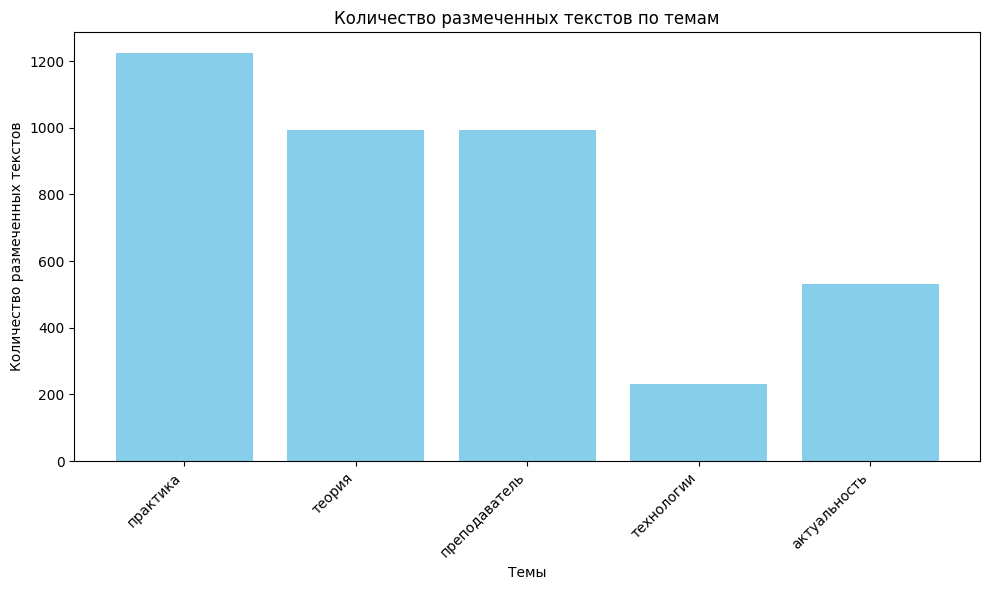

In [4]:
import matplotlib.pyplot as plt

print('Всего размеченных текстов -', len(df_dataset_index))
for t in create_dataset.topic_keywords:
	print(t, '-', len(df_dataset_index[df_dataset_index[t] == 1]))

# Создание списков для тем и их количества
topics = create_dataset.topic_keywords
counts = [len(df_dataset_index[df_dataset_index[t] == 1]) for t in topics]

# Визуализация
plt.figure(figsize=(10, 6))
plt.bar(topics, counts, color='skyblue')
plt.xlabel('Темы')
plt.ylabel('Количество размеченных текстов')
plt.title('Количество размеченных текстов по темам')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Размеченный и обработанный датасет

In [5]:
# Размечаем и обрабатываем датасет
df_marked: pd.DataFrame = df.loc[df_dataset_index.index]
for topic in create_dataset.topic_keywords:
	df_marked[topic] = df_dataset_index[topic]

# Векторизация текста и обучение модели

## Векторизация

In [6]:
# Размечаем и обрабатываем датасет
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score

# Векторизация текста
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(df_marked['PreprocessedText'])
y = df_marked.drop(['PreprocessedText', 'Reviews'], axis=1)
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, df_marked[create_dataset.topic_keywords],
													test_size=0.3,
													random_state=42)


## Обучение модели

In [7]:
# Обучаем модель классификации отзывов
# Используем многоцелевой классификатор
model = MultiOutputClassifier(DecisionTreeClassifier())
model.fit(X_train, y_train)

# Прогнозируем на тестовых данных
y_pred = model.predict(X_test)
# Оценка модели
print(classification_report(y_test, y_pred, target_names=y.columns, zero_division=0))
print(model.score(X_test, y_test))
print(f1_score(y_test, y_pred, average='macro'))

               precision    recall  f1-score   support

     практика       1.00      0.99      0.99       364
       теория       1.00      0.99      1.00       313
преподаватель       0.97      0.94      0.95       299
   технологии       0.98      0.94      0.96        62
 актуальность       1.00      0.97      0.98       160

    micro avg       0.99      0.97      0.98      1198
    macro avg       0.99      0.96      0.98      1198
 weighted avg       0.99      0.97      0.98      1198
  samples avg       0.98      0.97      0.97      1198

0.9416785206258891
0.9772966430707939


### Получим важность признаков


In [8]:
import numpy as np

for i, name in enumerate(list(y.columns)):
	importances = model.estimators_[i].feature_importances_

	# Отсортируем важность
	indices = np.argsort(importances)[::-1]

	# Напечатаем топ важнейших признаков
	feature_names = vectorizer.get_feature_names_out()
	top_n = 7
	print('-' * 32)
	print(f"Топ {top_n} важнейших слов для категории '{name}':")
	for i in range(top_n):
		if importances[indices[i]]:
			print(f"{feature_names[indices[i]]}: {importances[indices[i]]}")


--------------------------------
Топ 7 важнейших слов для категории 'практика':
задача: 0.43546026005338856
задание: 0.363239460933969
практика: 0.17001480993617088
проект: 0.021548382301146324
задачник: 0.00485605994307882
перевести: 0.0024436462959897738
биотех: 0.0024373805362565408
--------------------------------
Топ 7 важнейших слов для категории 'теория':
материал: 0.419455267426036
знание: 0.32633750111824344
теория: 0.14612466930330154
лекция: 0.10056279926123309
исчезли: 0.002511804253975681
стандартный: 0.0025065822077098036
презентация: 0.0025013764295004565
--------------------------------
Топ 7 важнейших слов для категории 'преподаватель':
автор: 0.32095309864714516
преподаватель: 0.13296353575729405
лектор: 0.09328184612737445
создатель: 0.08894315560982234
анатолий: 0.05518072613660851
учить: 0.03850939564340098
тимур: 0.03388533690867468
--------------------------------
Топ 7 важнейших слов для категории 'технологии':
доступно: 0.5832794008875739
проблема: 0.2101006288

### Проверка тестового текста

In [9]:
test_review = "Крутой курс! Мне понравились задачи и препод"
test_review = text_processor.preprocess(test_review)
new_vector = vectorizer.transform(pd.Series(test_review))
test_pred = model.predict(new_vector)
for i, k in enumerate(create_dataset.topic_keywords):
	print(k, ':', test_pred[0][i])

практика : 1
теория : 0
преподаватель : 1
технологии : 0
актуальность : 0


# Создание ответов

## Cоздание ответов с помощью модели

In [10]:
df_test = pd.read_csv('../data/test_reviews.csv', index_col=0)
df_test['Reviews'] = df_test['Reviews'].astype(str)
df_test['PreprocessedText'] = df_test['Reviews'].apply(text_processor.preprocess)
test_vector = vectorizer.transform(df_test['PreprocessedText'])

In [11]:
test_predict = pd.DataFrame(model.predict(test_vector))

In [12]:
for i, k in enumerate(create_dataset.topic_keywords):
	df_test[k] = test_predict[i]
df_pred = df_test.drop('PreprocessedText', axis=1)
df_pred.to_csv('../data/model_answer.csv', index=True)

## Разметка при помощи алгоритма

Получим нулевые классы

In [13]:
# Нулевые классы делают обучение bert более качественным
initial_void_index = list(set(df.index) - set(df_dataset_index.index))
initial_void_df = df.loc[initial_void_index]
initial_void_df = initial_void_df[
	initial_void_df['PreprocessedText'].str.split().str.len() <= 5]  # Берём строки с количеством слов <= n 

refined_void_df = pd.DataFrame()
for idx, row in initial_void_df.iterrows():
	text = row['PreprocessedText'].split()  # Предобработанный текст
	for key, keywords in create_dataset.topics.items():
		# Проверяем наличие ключевых слов в тексте с использованием нечеткого поиска
		if any(True for keyword in keywords for word in text if fuzz.ratio(word, keyword) > 67):
			break
	else:
		# Нет ключевых слов (нулевые классы)
		refined_void_df = pd.concat([refined_void_df, row.to_frame().T], ignore_index=True)
refined_void_df[create_dataset.topic_keywords] = 0
refined_void_df = refined_void_df[:100]

Соединим автоматическую разметку `train_reviews_bert` и нулевые классы 

In [14]:
# Размечаем и рандомно перемешиваем датасет
df_for_bert = pd.concat([refined_void_df.drop('PreprocessedText', axis=1), df_marked.drop('PreprocessedText', axis=1)],
						axis=0,
						ignore_index=True)
df_for_bert = df_for_bert.sample(frac=1).reset_index(drop=True)
df_for_bert.to_csv('../data/train_reviews_bert.csv', index=False)  # Можно использовать для обучения bert

Создание автоматической разметки `test_train`

In [15]:
import pandas as pd

df_test_index = create_dataset.automatic_annotation(df_test)

common_indices = df_test.index.intersection(df_test_index.index)

# Создадим копию df_test, чтобы избежать изменения исходного DataFrame
df_test_marked = df_test.copy()

# Заменим значения в df_test на значения из df_test_index для общих индексов
for idx in common_indices:
	df_test_marked.loc[idx, df_test_index.columns] = df_test_index.loc[idx]

100%|██████████| 1145/1145 [00:02<00:00, 571.75it/s]


## Комбинируем предсказания модели и автоматической разметки (логическое 'или')

In [16]:
# Предсказываем категории отзывов на основе обученной модели
df_comb = df_pred.copy()
df_comb['практика'] |= df_test_marked['практика']
df_comb['теория'] |= df_test_marked['теория']
df_comb['преподаватель'] |= df_test_marked['преподаватель']
df_comb['технологии'] |= df_test_marked['технологии']
df_comb['актуальность'] |= df_test_marked['актуальность']

df_comb.to_csv('../data/combined_answer.csv')